<a href="https://colab.research.google.com/github/gpdrishti/ML/blob/main/Reduced_SVD%26KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Import the data

In [ ]:
rating_cols=["User_ID","Movie_ID","Rating","Timestamp"]
rating_cols_1=["User_ID","gender","age","occupation","zipcode"]
movie_cols=["Movie_Id","Title","Genre"]

from google.colab import drive

drive.mount('/content/drive')
path_link = "/content/drive/MyDrive/ratings.dat"

rating_matrix=pd.read_csv(path_link,sep='::',header=None,names=rating_cols,engine='python')
user_matrix=pd.read_csv('/content/drive/MyDrive/users.dat',sep='::',header=None,names=rating_cols_1,engine='python')
movie_matrix=pd.read_csv('/content/drive/MyDrive/movies.dat',sep='::',header=None,names=movie_cols,engine='python',encoding='latin-1')

Mounted at /content/drive


In [ ]:
rating_matrix = rating_matrix.rename(columns={'Movie_ID': 'Movie_Id'})

# Merge rating matrix and movie matrix on Movie_Id

In [ ]:
merged_df = pd.merge(rating_matrix, movie_matrix, on='Movie_Id')

In [ ]:
merged_df.head()

,User_ID,Movie_Id,Rating,Timestamp,Title,Genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


# Separate out the genres
## Split a column containing multiple genres into separate rows, one for each genre




*   .assign(Genre=merged_df['Genre'].str.split('|')): This creates a new column Genre containing lists of genres obtained by splitting the original Genre column at the pipe (|) symbol.
*   .explode('Genre'): This expands each row into multiple rows, one for each genre in the list.




In [ ]:
merged_df = merged_df.assign(Genre=merged_df['Genre'].str.split('|')).explode('Genre').reset_index(drop=True)

In [ ]:
merged_df.head()

,User_ID,Movie_Id,Rating,Timestamp,Title,Genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
merged_df.shape

(2101815, 6)

# Extract the year from movie title

In [ ]:
def rm_dates_from_title(df: pd.DataFrame):

    #Extracts text enclosed in parentheses and containing four digits (\d\d\d\d) using regular expressions.
    df['year'] = df.Title.str.extract('(\(\d\d\d\d\))', expand=False)

    # extracts only the four digits (year) from the previously created year column: removing ()
    df['year'] = df.year.str.extract('(\d\d\d\d)', expand=False)

    # Replaces occurrences of the same pattern (\(\d\d\d\d\)) (year in parentheses) with an empty string ('')
    df['Title'] = df.Title.str.replace('(\(\d\d\d\d\))', '', regex=True)

    # Applying the strip function to get rid of any ending whitespace characters that may have appeared
    df['Title'] = df.Title.apply(lambda x: x.strip())

rm_dates_from_title(merged_df)

In [ ]:
merged_df.head()

,User_ID,Movie_Id,Rating,Timestamp,Title,Genre,year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,Drama,1975


# Assign weights to ratings based on recency of movies
The weight assigned to each rating is based on the age of the movie.
Movies released in the last 5 years are given a weight of 1.0.
Movies released between 5 and 10 years ago are given a weight of 0.8.
Movies released between 10 and 15 years ago are given a weight of 0.6.
Movies released more than 15 years ago are given a weight of 0.4.
This is because more recent movies are generally considered to be more relevant to users' current preferences.

In [ ]:
current_year = 2024

# Calculate the age of the movie
merged_df['age'] = current_year - merged_df['year'].astype(int)

# Define a function to calculate the weight based on the age of the movie
def weight_by_age(age):
    if age <= 5:
        return 1.0
    elif age <= 10:
        return 0.8
    elif age <= 15:
        return 0.6
    else:
        return 0.4

# Apply the weight function to the 'age' column and create a new 'weight' column
merged_df['weight'] = merged_df['age'].apply(weight_by_age)

# Multiply the rating by the weight to get the weighted rating
merged_df['weighted_rating'] = merged_df['Rating'] * merged_df['weight']
merged_df = merged_df.drop('Rating', axis=1)
merged_df = merged_df.rename(columns={'weighted_rating': 'Rating'})

merged_df = merged_df.drop('age', axis=1)
# Remove the years from the title of movies_df


In [ ]:
merged_df = merged_df.drop('weight', axis=1)

# Create a pivot table to get the average rating for each user and genre
### Each cell in the table will contain the average rating given by that user for that specific genre.

In [ ]:
ratings = merged_df.pivot_table(values='Rating', index='User_ID', columns='Genre', aggfunc='mean')

In [ ]:
null_counts = ratings.isnull().sum()
null_counts

Genre
Action           28
Adventure       146
Animation      1232
Children's      757
Comedy            9
Crime           378
Documentary    3797
Drama             3
Fantasy        1190
Film-Noir      1890
Horror          740
Musical        1286
Mystery         907
Romance          79
Sci-Fi          129
Thriller         51
War             271
Western        1940
dtype: int64

## we can see that documentary has a significant number of null values so we will drop this genre

In [ ]:
columns_to_drop = ['Documentary']
ratings.drop(columns=columns_to_drop, inplace=True)

### replace null values with zero

In [ ]:
ratings_filled=ratings.fillna(0)

#Normalize the rows of a matrix by dividing each row by its Euclidean norm.

    Parameters:
    matrix (numpy.ndarray): The matrix to be normalized.

    Returns:
    numpy.ndarray: The normalized matrix.

In [ ]:
def normalize_rows(matrix):

    # Calculate the Euclidean norm of each row
    row_norms = np.linalg.norm(matrix, axis=1, ord=2)

    # Normalize each row by dividing it by its Euclidean norm
    normalized_matrix = matrix / row_norms[:, np.newaxis]

    return normalized_matrix

In [ ]:
normalized_matrix = normalize_rows(ratings_filled)

### Now let us see the distribution of ratings of each genre

<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
<ipython-input-19-e4eb3c76e4bc>:9: UserWarning: Ignoring `palette` because no `hue` variable has been as

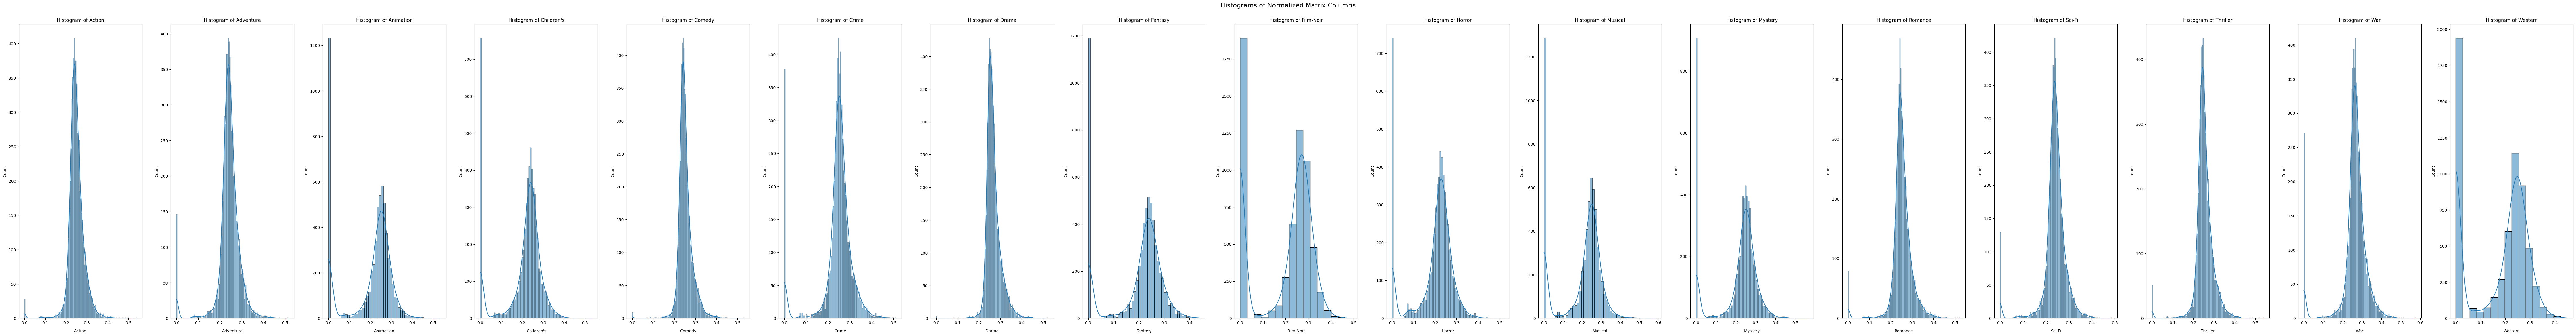

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust figure size (customize as needed)
fig, axes = plt.subplots(1, len(normalized_matrix.columns), figsize=(90, 12))

# Create informative and visually appealing histograms
for i, col in enumerate(normalized_matrix.columns):
    sns.histplot(
        data=normalized_matrix,
        x=col,
        kde=True,  # Add smooth kernel density estimate
        palette="colorblind",  # Use colorblind-friendly palette
        ax=axes[i]
    )
    axes[i].set_xlabel(col, labelpad=10)  # Add padding for readability
    axes[i].set_title(f"Histogram of {col}", fontsize=12)  # Customize title size

# Enhance overall plot appearance
plt.suptitle("Histograms of Normalized Matrix Columns", fontsize=16)
plt.tight_layout(pad=2)  # Adjust spacing between subplots
plt.show()


### now we can see that each genre is following gaussian distribution
### now we will replace null values with 0s

In [ ]:
ratings_filled=normalized_matrix.fillna(0)

In [ ]:
ratings_filled

Genre,Action,Adventure,Animation,Children's,Comedy,Crime,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
User_ID,,,,,,,,,,,,,,,,,
1,0.279125,0.265833,0.273217,0.282448,0.275327,0.265833,0.294315,0.265833,0.000000,0.000000,0.284821,0.000000,0.243680,0.287986,0.243680,0.332291,0.000000
2,0.258361,0.275844,0.000000,0.000000,0.262790,0.264513,0.287795,0.221452,0.295270,0.221452,0.000000,0.246058,0.273740,0.264875,0.257171,0.275585,0.319876
3,0.262283,0.265165,0.265165,0.265165,0.249697,0.000000,0.265165,0.298311,0.000000,0.176777,0.265165,0.198874,0.251907,0.254117,0.251907,0.265165,0.309359
4,0.292821,0.269963,0.000000,0.281701,0.000000,0.352126,0.293439,0.316914,0.000000,0.305176,0.000000,0.000000,0.281701,0.250401,0.246488,0.234751,0.316914
5,0.195506,0.224470,0.299293,0.286823,0.255201,0.245848,0.231664,0.000000,0.299293,0.209505,0.249411,0.233823,0.231952,0.229458,0.212959,0.261881,0.299293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.213938,0.213079,0.278959,0.245633,0.228419,0.251613,0.249978,0.213938,0.289446,0.212975,0.264547,0.243302,0.239073,0.202123,0.224126,0.269970,0.259782
6037,0.231005,0.253653,0.253653,0.232515,0.226783,0.243084,0.245888,0.269506,0.218423,0.260698,0.253653,0.234141,0.233476,0.234141,0.235002,0.253653,0.237799
6038,0.260257,0.347009,0.318092,0.260257,0.332550,0.000000,0.337370,0.000000,0.000000,0.216881,0.000000,0.000000,0.361468,0.347009,0.000000,0.347009,0.000000


# Applying SVD to ratings_filled matrix

### SVD is a fundamental technique in numerical linear algebra and machine learning for dimensionality reduction, data compression, and various other applications

## left singular vectors

In [ ]:
#This function calculates the Eigenvectors corresponding for U matrice
def calculU(M):
    B = np.dot(M, M.T)
    eigenvalues, eigenvectors = np.linalg.eig(B)
    ncols = np.argsort(eigenvalues)[::-1] #Sorts the eigenvalues in descending order.

    return eigenvectors[:,ncols]#returns a sub-matrix of eigenvectors. It selects all rows (':') and the columns specified by ncols

## right singular vectors

In [ ]:
#This function calculates the Eigenvectors corresponding for V matrice
def calculVt(M):
    B = np.dot(M.T, M)
    eigenvalues, eigenvectors = np.linalg.eig(B)
    ncols = np.argsort(eigenvalues)[::-1]

    return eigenvectors[:,ncols].T

## Singular values

In [ ]:
#Function that calculates Eigenvalues corresponding to the Sigma Matrix
def calculSigma(M):
    if (np.size(np.dot(M, M.T)) > np.size(np.dot(M.T, M))):
        newM = np.dot(M.T, M)
    else:
        newM = np.dot(M, M.T)

    eigenvalues, eigenvectors = np.linalg.eig(newM)
    eigenvalues = np.sqrt(eigenvalues)
    #Sorting in descending order as the svd function does
    return eigenvalues[::-1]

In [ ]:
#Calling the corresponding Fuctions and saving the values in variables

U = calculU(ratings_filled)
Sigma = calculSigma(ratings_filled)
Vt = calculVt(ratings_filled)


In [ ]:
print(U.shape,Sigma.shape,Vt.shape)

(6040, 6040) (17,) (17, 17)


In [ ]:
Sigma

array([ 2.6456251 ,  2.42395269,  3.17480119,  3.61770235,  1.78634591,
        4.13960733,  5.0475639 ,  5.23215987,  5.83153051,  6.6550315 ,
        6.89848452,  7.40768473,  7.94839906,  9.11865422, 10.68452978,
       11.94469948, 73.12220053])

In [ ]:
sigma = np.sort(Sigma)
print(sigma)

[ 1.78634591  2.42395269  2.6456251   3.17480119  3.61770235  4.13960733
  5.0475639   5.23215987  5.83153051  6.6550315   6.89848452  7.40768473
  7.94839906  9.11865422 10.68452978 11.94469948 73.12220053]


# Determining no. of singular values to keep and performing reduced SVD

## Scree plot

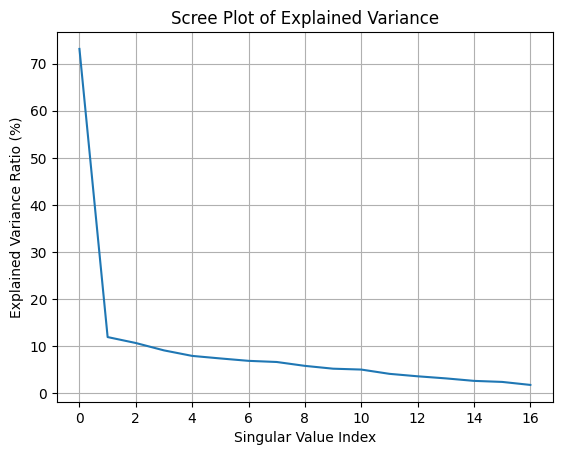

In [ ]:
sorted_sigma = np.sort(sigma)[::-1]
if not isinstance(sorted_sigma, np.ndarray):
    explained_variance_ratio = (sorted_sigma) / np.sum(sorted_sigma)
else:
    explained_variance_ratio = sorted_sigma

# Plot the scree plot
plt.plot(explained_variance_ratio)
plt.xlabel("Singular Value Index")
plt.ylabel("Explained Variance Ratio (%)")
plt.title("Scree Plot of Explained Variance")
plt.grid(True)
plt.show()

### elbow point index: 1
### so we will take top 2 singular values and perform reduced SVD

## Reduced SVD


In [ ]:
u_new = U[:, :2]
vt_new=Vt[:2,:]
sigma_new = np.zeros((2,2))
sigma_new[:2, :2] = np.diag(sorted_sigma[:2])


In [ ]:
print(u_new.shape,sigma_new.shape,vt_new.shape)

(6040, 2) (2, 2) (2, 17)


In [ ]:
sigma_new

array([[73.12220053,  0.        ],
       [ 0.        , 11.94469948]])

## Generate rating matrix from reduced SVD

In [ ]:
ratings_tilde=np.dot(np.dot(u_new,sigma_new),vt_new)
ratings_tilde

array([[0.19996913+0.j, 0.20397443+0.j, 0.24878076+0.j, ...,
        0.20786693+0.j, 0.22221106+0.j, 0.22782017+0.j],
       [0.22750896+0.j, 0.22474253+0.j, 0.21648861+0.j, ...,
        0.23371336+0.j, 0.24349185+0.j, 0.1875864 +0.j],
       [0.25122257+0.j, 0.24293254+0.j, 0.19147563+0.j, ...,
        0.25608553+0.j, 0.26220718+0.j, 0.15594727+0.j],
       ...,
       [0.14976493+0.j, 0.16059008+0.j, 0.25743913+0.j, ...,
        0.15865168+0.j, 0.17638414+0.j, 0.24714236+0.j],
       [0.28789309+0.j, 0.27355266+0.j, 0.17543632+0.j, ...,
        0.29162774+0.j, 0.29431965+0.j, 0.13138093+0.j],
       [0.2937722 +0.j, 0.27731087+0.j, 0.16240559+0.j, ...,
        0.2968889 +0.j, 0.29800298+0.j, 0.11618873+0.j]])

In [ ]:
ratings_dataframe=pd.DataFrame(ratings_tilde)
ratings_dataframe

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.199969+0.000000j,0.203974+0.000000j,0.248781+0.000000j,0.232455+0.000000j,0.207775+0.000000j,0.217091+0.000000j,0.217344+0.000000j,0.219464+0.000000j,0.275686+0.000000j,0.198694+0.000000j,0.244367+0.000000j,0.238783+0.000000j,0.210646+0.000000j,0.203999+0.000000j,0.207867+0.000000j,0.222211+0.000000j,0.227820+0.000000j
1,0.227509+0.000000j,0.224743+0.000000j,0.216489+0.000000j,0.216390+0.000000j,0.232164+0.000000j,0.231152+0.000000j,0.245019+0.000000j,0.202420+0.000000j,0.217330+0.000000j,0.197682+0.000000j,0.212558+0.000000j,0.223367+0.000000j,0.234032+0.000000j,0.223244+0.000000j,0.233713+0.000000j,0.243492+0.000000j,0.187586+0.000000j
2,0.251223+0.000000j,0.242933+0.000000j,0.191476+0.000000j,0.204575+0.000000j,0.253341+0.000000j,0.243924+0.000000j,0.268943+0.000000j,0.189727+0.000000j,0.171124+0.000000j,0.198002+0.000000j,0.187915+0.000000j,0.212119+0.000000j,0.254405+0.000000j,0.240186+0.000000j,0.256086+0.000000j,0.262207+0.000000j,0.155947+0.000000j
3,0.188948+0.000000j,0.192150+0.000000j,0.229769+0.000000j,0.215815+0.000000j,0.195988+0.000000j,0.203865+0.000000j,0.205186+0.000000j,0.203604+0.000000j,0.252821+0.000000j,0.185484+0.000000j,0.225685+0.000000j,0.221777+0.000000j,0.198589+0.000000j,0.192051+0.000000j,0.196190+0.000000j,0.209222+0.000000j,0.209561+0.000000j
4,0.288771+0.000000j,0.271865+0.000000j,0.153047+0.000000j,0.186717+0.000000j,0.286949+0.000000j,0.264428+0.000000j,0.306865+0.000000j,0.170466+0.000000j,0.099663+0.000000j,0.199009+0.000000j,0.150054+0.000000j,0.195163+0.000000j,0.286764+0.000000j,0.267170+0.000000j,0.291560+0.000000j,0.292007+0.000000j,0.107116+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.298286+0.000000j,0.280729+0.000000j,0.157246+0.000000j,0.192259+0.000000j,0.296349+0.000000j,0.272940+0.000000j,0.316947+0.000000j,0.175483+0.000000j,0.101727+0.000000j,0.205207+0.000000j,0.154168+0.000000j,0.200981+0.000000j,0.296141+0.000000j,0.275860+0.000000j,0.301130+0.000000j,0.301509+0.000000j,0.109738+0.000000j
6036,0.286498+0.000000j,0.272594+0.000000j,0.177924+0.000000j,0.204088+0.000000j,0.286346+0.000000j,0.268552+0.000000j,0.305334+0.000000j,0.187648+0.000000j,0.136626+0.000000j,0.208563+0.000000j,0.174526+0.000000j,0.212555+0.000000j,0.286710+0.000000j,0.268534+0.000000j,0.290354+0.000000j,0.293361+0.000000j,0.134335+0.000000j
6037,0.149765+0.000000j,0.160590+0.000000j,0.257439+0.000000j,0.225470+0.000000j,0.160127+0.000000j,0.179510+0.000000j,0.165191+0.000000j,0.214875+0.000000j,0.309399+0.000000j,0.179132+0.000000j,0.252967+0.000000j,0.230448+0.000000j,0.163771+0.000000j,0.162240+0.000000j,0.158652+0.000000j,0.176384+0.000000j,0.247142+0.000000j
6038,0.287893+0.000000j,0.273553+0.000000j,0.175436+0.000000j,0.202659+0.000000j,0.287527+0.000000j,0.269062+0.000000j,0.306707+0.000000j,0.186180+0.000000j,0.132438+0.000000j,0.208148+0.000000j,0.172077+0.000000j,0.211156+0.000000j,0.287823+0.000000j,0.269396+0.000000j,0.291628+0.000000j,0.294320+0.000000j,0.131381+0.000000j


In [ ]:
ratings_dataframe=ratings_dataframe.apply(np.real)
ratings_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.199969,0.203974,0.248781,0.232455,0.207775,0.217091,0.217344,0.219464,0.275686,0.198694,0.244367,0.238783,0.210646,0.203999,0.207867,0.222211,0.227820
1,0.227509,0.224743,0.216489,0.216390,0.232164,0.231152,0.245019,0.202420,0.217330,0.197682,0.212558,0.223367,0.234032,0.223244,0.233713,0.243492,0.187586
2,0.251223,0.242933,0.191476,0.204575,0.253341,0.243924,0.268943,0.189727,0.171124,0.198002,0.187915,0.212119,0.254405,0.240186,0.256086,0.262207,0.155947
3,0.188948,0.192150,0.229769,0.215815,0.195988,0.203865,0.205186,0.203604,0.252821,0.185484,0.225685,0.221777,0.198589,0.192051,0.196190,0.209222,0.209561
4,0.288771,0.271865,0.153047,0.186717,0.286949,0.264428,0.306865,0.170466,0.099663,0.199009,0.150054,0.195163,0.286764,0.267170,0.291560,0.292007,0.107116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.298286,0.280729,0.157246,0.192259,0.296349,0.272940,0.316947,0.175483,0.101727,0.205207,0.154168,0.200981,0.296141,0.275860,0.301130,0.301509,0.109738
6036,0.286498,0.272594,0.177924,0.204088,0.286346,0.268552,0.305334,0.187648,0.136626,0.208563,0.174526,0.212555,0.286710,0.268534,0.290354,0.293361,0.134335
6037,0.149765,0.160590,0.257439,0.225470,0.160127,0.179510,0.165191,0.214875,0.309399,0.179132,0.252967,0.230448,0.163771,0.162240,0.158652,0.176384,0.247142
6038,0.287893,0.273553,0.175436,0.202659,0.287527,0.269062,0.306707,0.186180,0.132438,0.208148,0.172077,0.211156,0.287823,0.269396,0.291628,0.294320,0.131381


### Yay !! we got our noiseless rating matrix



.

## normalization

In [ ]:
ratings_dataframe=((ratings_dataframe-ratings_dataframe.min()) / (ratings_dataframe.max()-ratings_dataframe.min())) * 4 + 1
ratings_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.143788,3.244558,3.589652,3.867219,3.194823,3.508608,3.168201,3.806409,3.431940,4.399317,3.588673,3.900734,3.213808,3.272919,3.175834,3.267231,3.486891
1,3.613898,3.687292,3.069732,3.393771,3.651069,3.873002,3.631679,3.322780,2.892387,4.357737,3.068589,3.434224,3.664896,3.707949,3.637238,3.703806,2.952812
2,4.018693,4.075067,2.667010,3.045557,4.047243,4.203990,4.032350,2.962624,2.465166,4.370859,2.665675,3.093859,4.057864,4.090933,4.036620,4.087751,2.532822
3,2.955664,2.992480,3.283557,3.376816,2.974310,3.165869,2.964584,3.356384,3.220530,3.856499,3.283229,3.386110,2.981246,3.002842,2.967372,3.000764,3.244516
4,4.659658,4.691843,2.048288,2.519256,4.675958,4.735349,4.667455,2.416075,1.804450,4.412268,2.046627,2.580777,4.682022,4.700902,4.669893,4.699085,1.884617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,4.822065,4.880812,2.115899,2.682604,4.851818,4.955922,4.836297,2.558448,1.823528,4.666915,2.113901,2.756833,4.862886,4.897347,4.840747,4.894031,1.919422
6036,4.620844,4.707390,2.448813,3.031200,4.664676,4.842224,4.641811,2.903609,2.146206,4.804812,2.446760,3.107063,4.680980,4.731748,4.648367,4.726862,2.245934
6037,2.286795,2.319691,3.729056,3.661358,2.303455,2.534717,2.294765,3.676190,3.743653,3.595490,3.729295,3.648510,2.309653,2.328949,2.297256,2.327092,3.743382
6038,4.644664,4.727826,2.408768,2.989094,4.686782,4.855439,4.664811,2.861954,2.107481,4.787797,2.406722,3.064737,4.702449,4.751232,4.671110,4.746538,2.206719


## visualizing the ratings matrix data

In [ ]:
# TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(ratings_dataframe.values)

<ipython-input-38-d6abd8653b45>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='tsne-1', ylabel='tsne-2'>

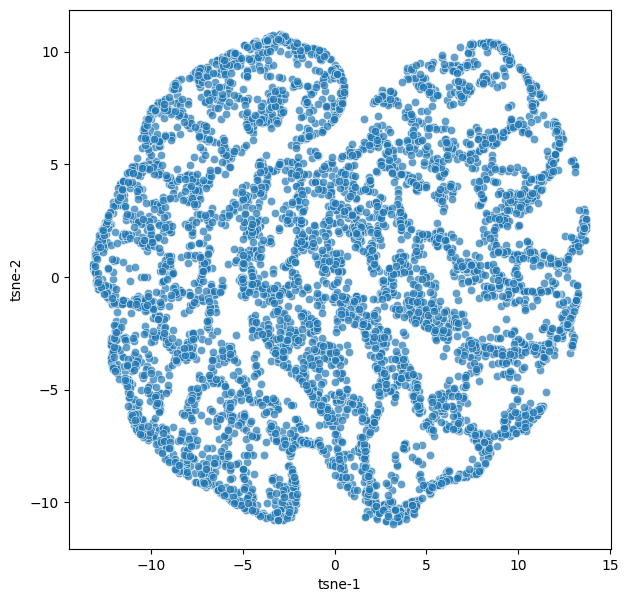

In [ ]:
# TSNE 2D Plot
df_tsne = pd.DataFrame(tsne_results, columns=['tsne-1', 'tsne-2'])

plt.figure(figsize=(7,7))

sns.scatterplot(
    x="tsne-1", y="tsne-2",
    palette=sns.color_palette("deep", 15),
    data=df_tsne,
    legend="full",
    alpha=0.7
)

### Instead of islands of distinct groups, the data points are more like a scattered archipelago.

## K Means++ on ratings matrix

### finding appropriate K using elbow method

In [ ]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1,40):
    km = KMeans(n_clusters=i)
    km.fit_predict(ratings_dataframe)
    wcss.append(km.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

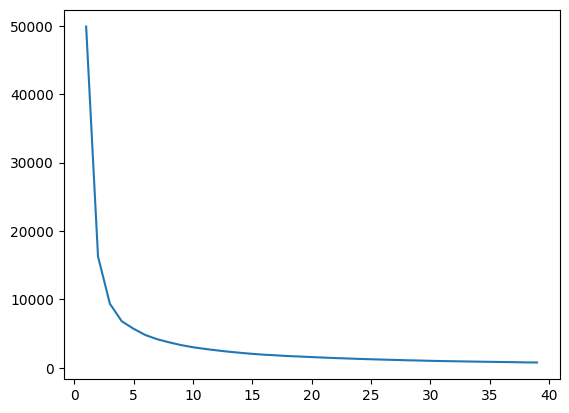

In [ ]:
plt.plot(range(1,40),wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

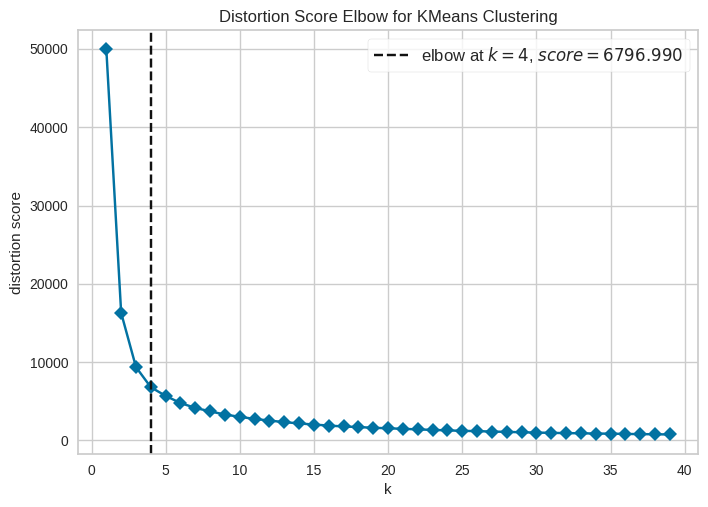

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer=KElbowVisualizer(model,k=(1,40),timings=False)
visualizer.fit(ratings_dataframe)
visualizer.show()

In [ ]:
k=4

### Perform k means++ on ratings matrix

In [ ]:
import sys

# function to compute euclidean distance
def distance(p1, p2):
    return np.sum((p1 - p2)**2)

# initialization algorithm
def initialize(data, k):

    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    centroids.append(data[np.random.randint(
            data.shape[0]), :])
    #plot(data, np.array(centroids))

    ## compute remaining k - 1 centroids
    for c_id in range(k - 1):

        ## initialize a list to store distances of data
        ## points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize

            ## compute distance of 'point' from each of the previously
            ## selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)

        ## select data point with maximum distance as our next centroid
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
        #plot(data, np.array(centroids))
    return centroids


# call the initialize function to get the centroids
centroids_df = initialize(ratings_dataframe.to_numpy(), k)
centroids_df_1=pd.DataFrame(centroids_df)

In [ ]:
centroids_df_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.800070,3.815461,2.540118,2.778228,3.807865,3.893327,3.803799,2.726062,2.409666,3.989030,2.539278,2.807926,3.810764,3.819793,3.804965,3.818924,2.454143
1,1.129784,1.204277,4.831737,4.592640,1.167511,1.570126,1.147831,4.645022,4.924533,3.505313,4.832580,4.555338,1.181545,1.225243,1.153474,1.221038,4.900885
2,1.516379,1.237492,2.133179,1.200350,1.375136,1.000000,1.448815,1.404717,2.593346,1.000000,2.136468,1.074034,1.322594,1.159000,1.427690,1.174743,2.447103
3,2.753142,2.912269,4.266110,4.583837,2.833732,3.299419,2.791693,4.514228,4.083437,4.699827,4.264989,4.621781,2.863711,2.957055,2.803746,2.948073,4.147517


In [ ]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x)**2).sum(axis=1)))
    return distances.idxmin(axis=1)

def new_centroids(data, labels, K):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

def kmeans(data, K, max_iterations=300):
    centroids = centroids_df_1.T
    old_centroids = pd.DataFrame()
    iteration = 1

    while iteration < max_iterations and not centroids.equals(old_centroids):
        old_centroids = centroids
        labels = get_labels(data, centroids)
        centroids = new_centroids(data, labels, k)  # calculate new centroids based on the cluster assignments
        iteration += 1

    return labels.values  # return the array containing the cluster index for each data point

cluster_labels = kmeans(ratings_dataframe, k)
print("Cluster Labels:", cluster_labels)

Cluster Labels: [2 3 3 ... 1 0 0]


## visualization of clusters

<Axes: xlabel='tsne-1', ylabel='tsne-2'>

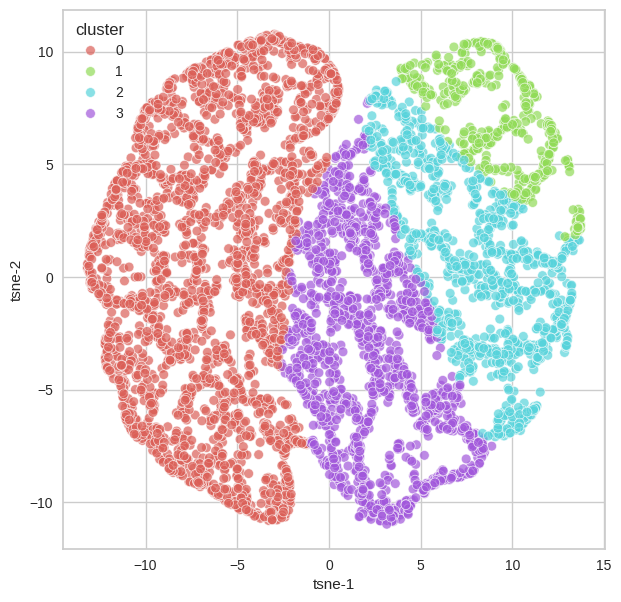

In [ ]:
df_tsne['cluster'] = cluster_labels

plt.figure(figsize=(7,7))

sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="cluster",
    palette=sns.color_palette("hls", n_colors=k),
    data=df_tsne,
    legend="full",
    alpha=0.7
)

In [ ]:
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2, 3]), array([2797,  526, 1134, 1583]))

## Now a new user comes

In [ ]:
def newUser(R, M, merged_df):
    user_vector = {}

    for i in range(len(R)):
        rating = R[i]
        movie_title = M[i]
        genres = merged_df.loc[merged_df['Title'] == movie_title, 'Genre'].tolist() if movie_title in merged_df['Title'].values else []

        # Add the rating to the user vector for each genre
        for genre in genres:
            if genre not in user_vector:
                user_vector[genre] = [rating]
            else:
                user_vector[genre].append(rating)

    # Calculate the mean rating for each genre
    mean_user_vector = {}
    for genre, ratings in user_vector.items():
        mean_rating = sum(ratings) / len(ratings) if len(ratings) > 0 else 0
        mean_user_vector[genre] = mean_rating

    return mean_user_vector

In [ ]:
#new_user_ratings = [4,4]
#new_user_movies = ["Tom and Huck","Sudden Death"]
new_user_ratings=[]
new_user_movies=[]
inpM = "x"
inpR = 100

while inpM != "NULL" and inpR != 0:
#     # Take movie name from the user
     inpM = input("Enter the movie name (type 'NULL' to exit): ")

#     # Check if the user wants to exit
     if inpM == "NULL":
         break

#     # Take rating from the user
     inpR = int(input("Enter the rating (type 0 to exit): "))

#     # Check if the user wants to exit
     if inpR == 0:
         break

#     # Append the rating and movie to the respective lists
     new_user_ratings.append(inpR)
     new_user_movies.append(inpM)

# Display the collected ratings and movies
print("New User Ratings:", new_user_ratings)
print("New User Movies:", new_user_movies)
ratings_dict = {}


# newUser(new_user_ratings , new_user_movies ,ratings_dict ,merged_df)
# print(ratings_dict)
# Call the newUser function
mean_user_vector = newUser(new_user_ratings, new_user_movies, merged_df)

# Display the mean user vector
print("Mean User Vector:")
print(mean_user_vector)

Enter the movie name (type 'NULL' to exit): Tom and Huck
Enter the rating (type 0 to exit): 4
Enter the movie name (type 'NULL' to exit): Sudden Death
Enter the rating (type 0 to exit): 4
Enter the movie name (type 'NULL' to exit): NULL
New User Ratings: [4, 4]
New User Movies: ['Tom and Huck', 'Sudden Death']
Mean User Vector:
{'Adventure': 4.0, "Children's": 4.0, 'Action': 4.0}


In [ ]:
def convert_to_vector(mean_user_vector, rating_matrix_genres):
    # Extract genre names from rating matrix and mean_user_vector, and sort them alphabetically
    all_genres = sorted(set(mean_user_vector.keys()).union(rating_matrix_genres))

    # Create a vector with values in the same order as the genres
    vector = [mean_user_vector.get(genre, 0) for genre in all_genres]

    return vector

In [ ]:
row_data = convert_to_vector(mean_user_vector,normalized_matrix)

# Display the resulting row
print("Converted Row:")
print(row_data)
def replace_zeros_with_mean(row_vector):
    # Calculate the mean value of the row vector
    non_zero_elements = [element for element in row_vector if element != 0]
    if non_zero_elements:
        mean_value = sum(non_zero_elements) / len(non_zero_elements)
    else:
        mean_value = 0

    # Replace all occurrences of 0 with the mean value
    replaced_vector = [mean_value if element == 0 else element for element in row_vector]

    return replaced_vector
new_row_vector = replace_zeros_with_mean(row_data)
print(new_row_vector)



Converted Row:
[4.0, 4.0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


## Assign a cluster to this new user

In [ ]:
new_user = new_row_vector
def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def assign_to_cluster(new_vector, centroids_df):
    distances = centroids_df.apply(lambda row: euclidean_distance(new_vector, row), axis=1)
    assigned_cluster = distances.idxmin()
    return assigned_cluster

new_vector = np.array(new_user)

assigned_cluster = assign_to_cluster(new_vector, centroids_df_1)
print(f"The new vector is assigned to cluster {assigned_cluster}")

The new vector is assigned to cluster 3


In [ ]:
items_in_cluster = ratings_dataframe[cluster_labels == assigned_cluster]

In [ ]:
items_in_cluster

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.143788,3.244558,3.589652,3.867219,3.194823,3.508608,3.168201,3.806409,3.431940,4.399317,3.588673,3.900734,3.213808,3.272919,3.175834,3.267231,3.486891
3,2.955664,2.992480,3.283557,3.376816,2.974310,3.165869,2.964584,3.356384,3.220530,3.856499,3.283229,3.386110,2.981246,3.002842,2.967372,3.000764,3.244516
11,3.458820,3.546104,3.274596,3.594056,3.503025,3.765571,3.479966,3.524067,3.098095,4.407747,3.273469,3.633611,3.519469,3.570670,3.486577,3.565743,3.158581
19,2.901925,2.985492,3.642398,3.826843,2.944248,3.238887,2.922170,3.786434,3.531053,4.187043,3.641748,3.847832,2.959992,3.009011,2.928500,3.004294,3.571169
37,3.188693,3.289783,3.560131,3.848629,3.239890,3.551129,3.213184,3.785424,3.397143,4.417262,3.559113,3.883646,3.258935,3.318234,3.220841,3.312527,3.453744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,3.296670,3.281564,2.686333,2.742366,3.289020,3.345899,3.293011,2.730090,2.646231,3.586856,2.686135,2.747513,3.286174,3.277313,3.291866,3.278165,2.661870
6011,3.192557,3.234992,3.154812,3.314434,3.214048,3.400525,3.202837,3.279464,3.059390,3.980535,3.154249,3.332782,3.222043,3.246935,3.206052,3.244540,3.093591
6014,3.522621,3.612076,3.244433,3.583220,3.567926,3.830498,3.544293,3.508997,3.058445,4.446062,3.243238,3.625402,3.584779,3.637253,3.551069,3.632204,3.121935
6026,2.836034,2.962814,3.985537,4.250577,2.900242,3.291324,2.866748,4.192511,3.831303,4.486953,3.984603,4.281866,2.924127,2.998495,2.876351,2.991339,3.885777


In [ ]:
user_ids_list = items_in_cluster.index.tolist()

## Movies watched by the users of that cluster

In [ ]:
# Filter DataFrame to include only users of interest
filtered_df = merged_df[merged_df['User_ID'].isin(user_ids_list)]

# Group by movie_id and calculate average rating
average_ratings = filtered_df.groupby('Movie_Id')['Rating'].mean().reset_index()

In [ ]:
average_ratings

,Movie_Id,Rating
0,1,1.633503
1,2,1.251724
2,3,1.200000
3,4,1.094118
4,5,1.185714
...,...,...
3430,3948,1.442105
3431,3949,1.644444
3432,3950,1.428571
3433,3951,1.480000


# Get the recommendations

In [ ]:
# Assuming 'movie_ratings' is your DataFrame with columns 'Movie_Id' and 'Rating'
movie_ratings_sorted = average_ratings.sort_values(by='Rating', ascending=False)

# Display the sorted DataFrame
print(movie_ratings_sorted)


      Movie_Id  Rating
1806      2129     2.0
2150      2503     2.0
1469      1741     2.0
732        854     2.0
529        567     2.0
...        ...     ...
1841      2164     0.4
715        834     0.4
1226      1433     0.4
628        706     0.4
3376      3891     0.4

[3435 rows x 2 columns]


In [ ]:
movie_matrix[movie_matrix['Movie_Id']==567]

,Movie_Id,Title,Genre
563,567,Kika (1993),Drama
